In [1]:
import pandas as pd 
import numpy as np 
import re
import json 

In [2]:
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

What is the state breakdown of the gendered phrases?

In [3]:
masculine_themed_wording = [
    "competitive",
    "dominate",
    "leader",
    "rock star",
    "rockstar",
    "guru",
    "ninja",
    "hacker",
    "superhero",
    "prove themselves",
    "analyze",
    "determine",
    "crush it",
    "world class",
    "superior",
    "ambitious",
    "aggressive",
]

In [4]:
data_set = pd.read_csv("../data/dice/us-technology-jobs-on-dicecom/dice_com-job_us_sample.csv")
data_set = data_set.get(['jobtitle','jobdescription','joblocation_address'])
states = pd.read_csv("states.csv")

In [5]:
data_set['State'] = data_set['joblocation_address'].apply(lambda x: pd.Series(str(x).split(", ")[-1]))

In [6]:
data_set.head()

,jobtitle,jobdescription,joblocation_address,State
0,AUTOMATION TEST ENGINEER,Looking for Selenium engineers...must have sol...,"Atlanta, GA",GA
1,Information Security Engineer,The University of Chicago has a rapidly growin...,"Chicago, IL",IL
2,Business Solutions Architect,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",IL
3,"Java Developer (mid level)- FT- GREAT culture,...",Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL",IL
4,DevOps Engineer,Midtown based high tech firm has an immediate ...,"Atlanta, GA",GA


In [7]:
def stem_tokens(s): 
    ps = PorterStemmer()
    tokens = word_tokenize(s)
    stem = list(map(lambda x : ps.stem(x), tokens))
    
    return stem 

In [8]:
def createTokenizedJobDescriptionDict(df): 
    descriptions = {}
    for index, row in df.iterrows(): 
        descriptions[index] = stem_tokens(row.get("jobdescription"))
    return descriptions

In [9]:
descriptionDict = createTokenizedJobDescriptionDict(data_set)

In [10]:
ps = PorterStemmer()

In [11]:
def numOfOcurrences(tokenizedPhrase, tokenizedDescription): 
    counter = 0
    i = len(tokenizedPhrase)
    for x in range(len(tokenizedDescription)-i + 1):
        if tokenizedDescription[x:x+i] == tokenizedPhrase:
            counter += 1; 
    return counter

In [136]:
def phraseCount(phrase, description): 
    #this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

1

In [72]:
def indicesOfJobsWithPhrase(phrase, df, descriptionDict): 
    indices = []
    for index, row in df.iterrows(): 
        tokenizedPhrase = stem_tokens(phrase)
        
        if numOfOcurrences(tokenizedPhrase, descriptionDict[index]) > 0 \
        or phraseCount(phrase,row.get("jobdescription")) > 0: 
            indices.append(index)
    return indices

In [13]:
def computeStateInfo(state, full_df,descriptions): 
    stateInfo = {}
    stateInfo['region'] = state
    stateInfo['word_count'] = {}
    state_df = full_df.where(full_df['State'] == state).dropna()
    biasedIndices = []; 
    
    for word in masculine_themed_wording: 
        
        indices = indicesOfJobsWithPhrase(word, state_df, descriptions)
        stateInfo['word_count'][word] = len(indices)
        biasedIndices += indices
    
    topWords = [item[0] for item in reversed(sorted(stateInfo['word_count'].items(), key = lambda kv: kv[1]))][:5]
    
    stateInfo['numberOfJobsInDataSet'] = len(state_df)
    stateInfo['numberOfBiasedJobs'] = len(set(biasedIndices))
    try: 
        stateInfo['percentageOfBiasedJobs'] = float(stateInfo['numberOfBiasedJobs']/ stateInfo['numberOfJobsInDataSet']) * 100
    except ZeroDivisionError: 
        stateInfo['percentageOfBiasedJobs'] = 'NA'
        #     stateInfo['biasedIndices'] = list(set(biasedIndices))
                                                                                                               
    stateInfo['questionFour'] = topWords
    stateInfo['questionFive'] = {kv[0]: (kv[1] / stateInfo['numberOfJobsInDataSet'] * 100 if stateInfo['numberOfJobsInDataSet'] > 0 else 'NA')
                                         for kv in stateInfo['word_count'].items()}
#     del(stateInfo['word_count'])
    return stateInfo
    

In [38]:
def exportInfo(DF): 
    data = [computeStateInfo(state, DF,descriptionDict) for state in states['Code']]
    stateData = data; 
    with open('stateData.json', 'w') as outfile:
        json.dump(stateData, outfile,indent = 4)
    return stateData
        

In [39]:
import time

startTime = time.time()
stateData = exportInfo(data_set)
runtime = time.time() - startTime
runtime

134.3325560092926

In [40]:
stateData

[{'region': 'AL',
  'word_count': {'competitive': 5,
   'dominate': 0,
   'leader': 11,
   'rock star': 0,
   'rockstar': 0,
   'guru': 0,
   'ninja': 0,
   'hacker': 0,
   'superhero': 0,
   'prove themselves': 0,
   'analyze': 5,
   'determine': 4,
   'crush it': 0,
   'world class': 0,
   'superior': 0,
   'ambitious': 0,
   'aggressive': 1},
  'numberOfJobsInDataSet': 24,
  'numberOfBiasedJobs': 19,
  'percentageOfBiasedJobs': 79.16666666666666,
  'questionFour': ['leader',
   'analyze',
   'competitive',
   'determine',
   'aggressive'],
  'questionFive': {'competitive': 20.833333333333336,
   'dominate': 0.0,
   'leader': 45.83333333333333,
   'rock star': 0.0,
   'rockstar': 0.0,
   'guru': 0.0,
   'ninja': 0.0,
   'hacker': 0.0,
   'superhero': 0.0,
   'prove themselves': 0.0,
   'analyze': 20.833333333333336,
   'determine': 16.666666666666664,
   'crush it': 0.0,
   'world class': 0.0,
   'superior': 0.0,
   'ambitious': 0.0,
   'aggressive': 4.166666666666666}},
 {'region': 

In [53]:
D = {word: 0 for word in masculine_themed_wording}
for state in stateData: 
    for word in state['word_count']: 
        D[word] += state['word_count'][word]
D

{'competitive': 1998,
 'dominate': 26,
 'leader': 4659,
 'rock star': 28,
 'rockstar': 13,
 'guru': 70,
 'ninja': 15,
 'hacker': 32,
 'superhero': 1,
 'prove themselves': 9,
 'analyze': 3290,
 'determine': 1676,
 'crush it': 0,
 'world class': 167,
 'superior': 502,
 'ambitious': 89,
 'aggressive': 242}

In [71]:
hundred = { k:v for k,v in D.items() if D[k] < 100}
fiveHundred = { k:v for k,v in D.items() if D[k] < 1000 and k not in hundred}
biggest = {k:v for k,v in D.items() if k not in hundred and k not in fiveHundred}

print('hundred:', hundred)
print('fiveHundred:', fiveHundred)
print('biggest:', biggest)

hundred: {'dominate': 26, 'rock star': 28, 'rockstar': 13, 'guru': 70, 'ninja': 15, 'hacker': 32, 'superhero': 1, 'prove themselves': 9, 'crush it': 0, 'ambitious': 89}
fiveHundred: {'world class': 167, 'superior': 502, 'aggressive': 242}
biggest: {'competitive': 1998, 'leader': 4659, 'analyze': 3290, 'determine': 1676}


In [58]:
%matplotlib inline

In [42]:
import matplotlib.pyplot as plt

In [76]:
%matplotlib notebook

<IPython.core.display.Javascript object>


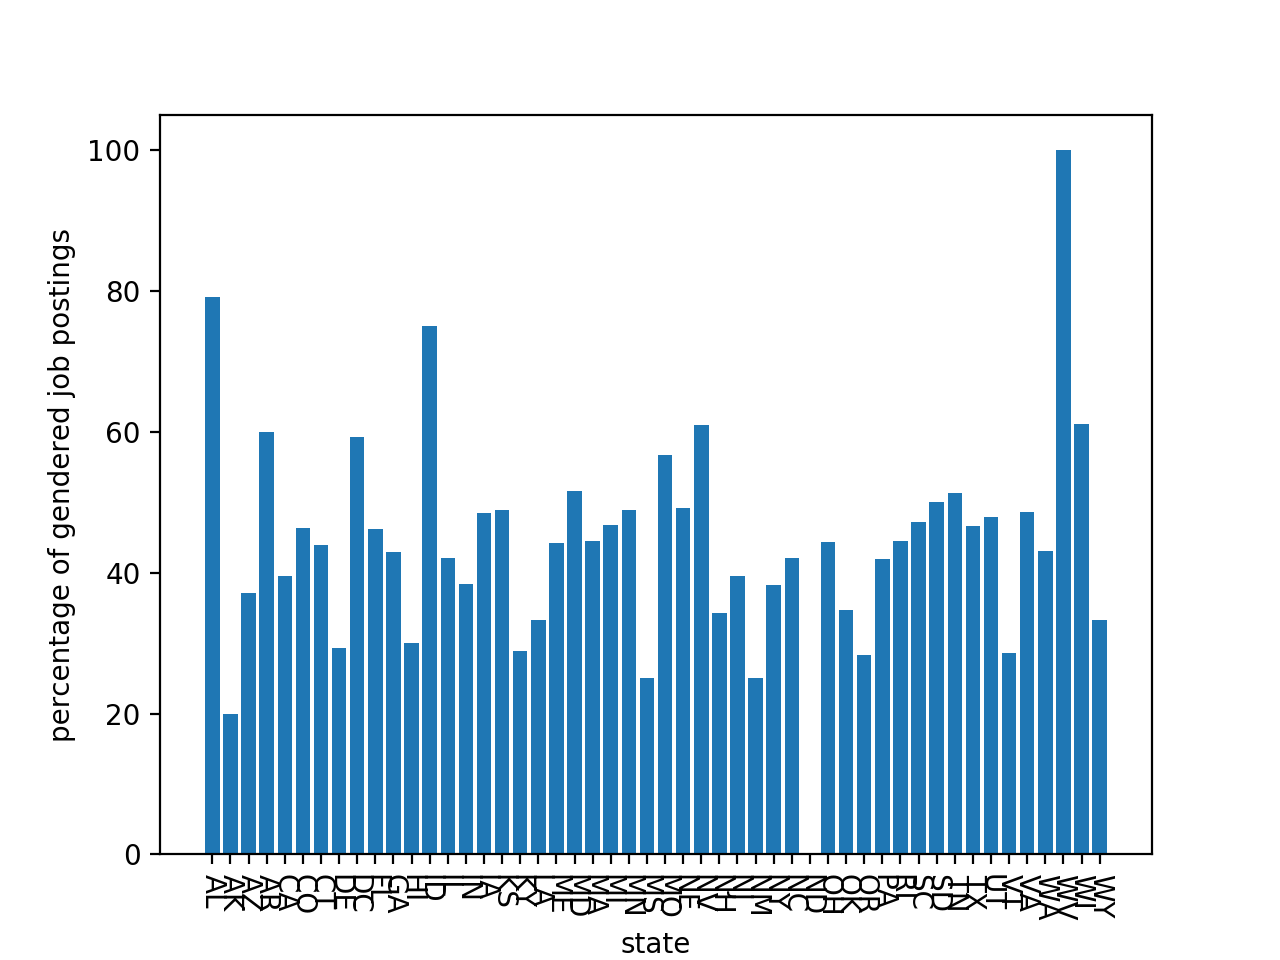

In [89]:
fig1 , ax = plt.subplots()

In [78]:
x = [state['region'] for state in stateData if state['percentageOfBiasedJobs'] != 'NA']

In [79]:
y = [float(state['percentageOfBiasedJobs']) for state in stateData if state['percentageOfBiasedJobs'] != 'NA']

In [90]:
ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')

Text(85.06944444444443, 0.5, 'percentage of gendered job postings')

<IPython.core.display.Javascript object>


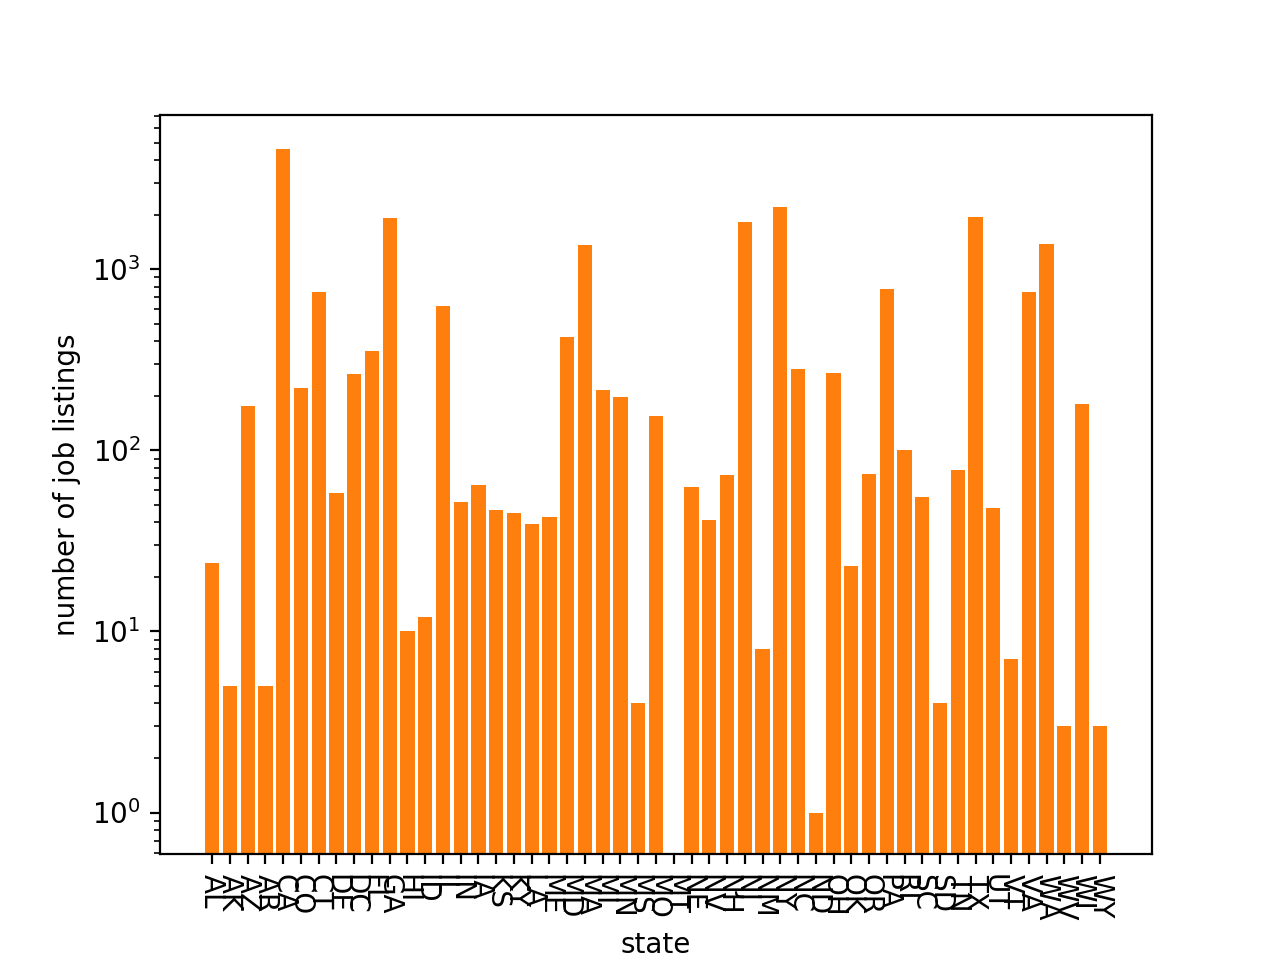

In [82]:
fig2, ax2 = plt.subplots()
plt.yscale('log')

In [83]:
x2 = [state['region'] for state in stateData] 

In [84]:
y2 = [state['numberOfJobsInDataSet'] for state in stateData]

In [91]:
ax2.bar(x2,y2)
ax2.tick_params(axis='x', which='major', rotation = 270)
ax2.set_ylabel('number of job listings')
ax2.set_xlabel('state')

Text(0.5, 28.544444444444434, 'state')

<IPython.core.display.Javascript object>


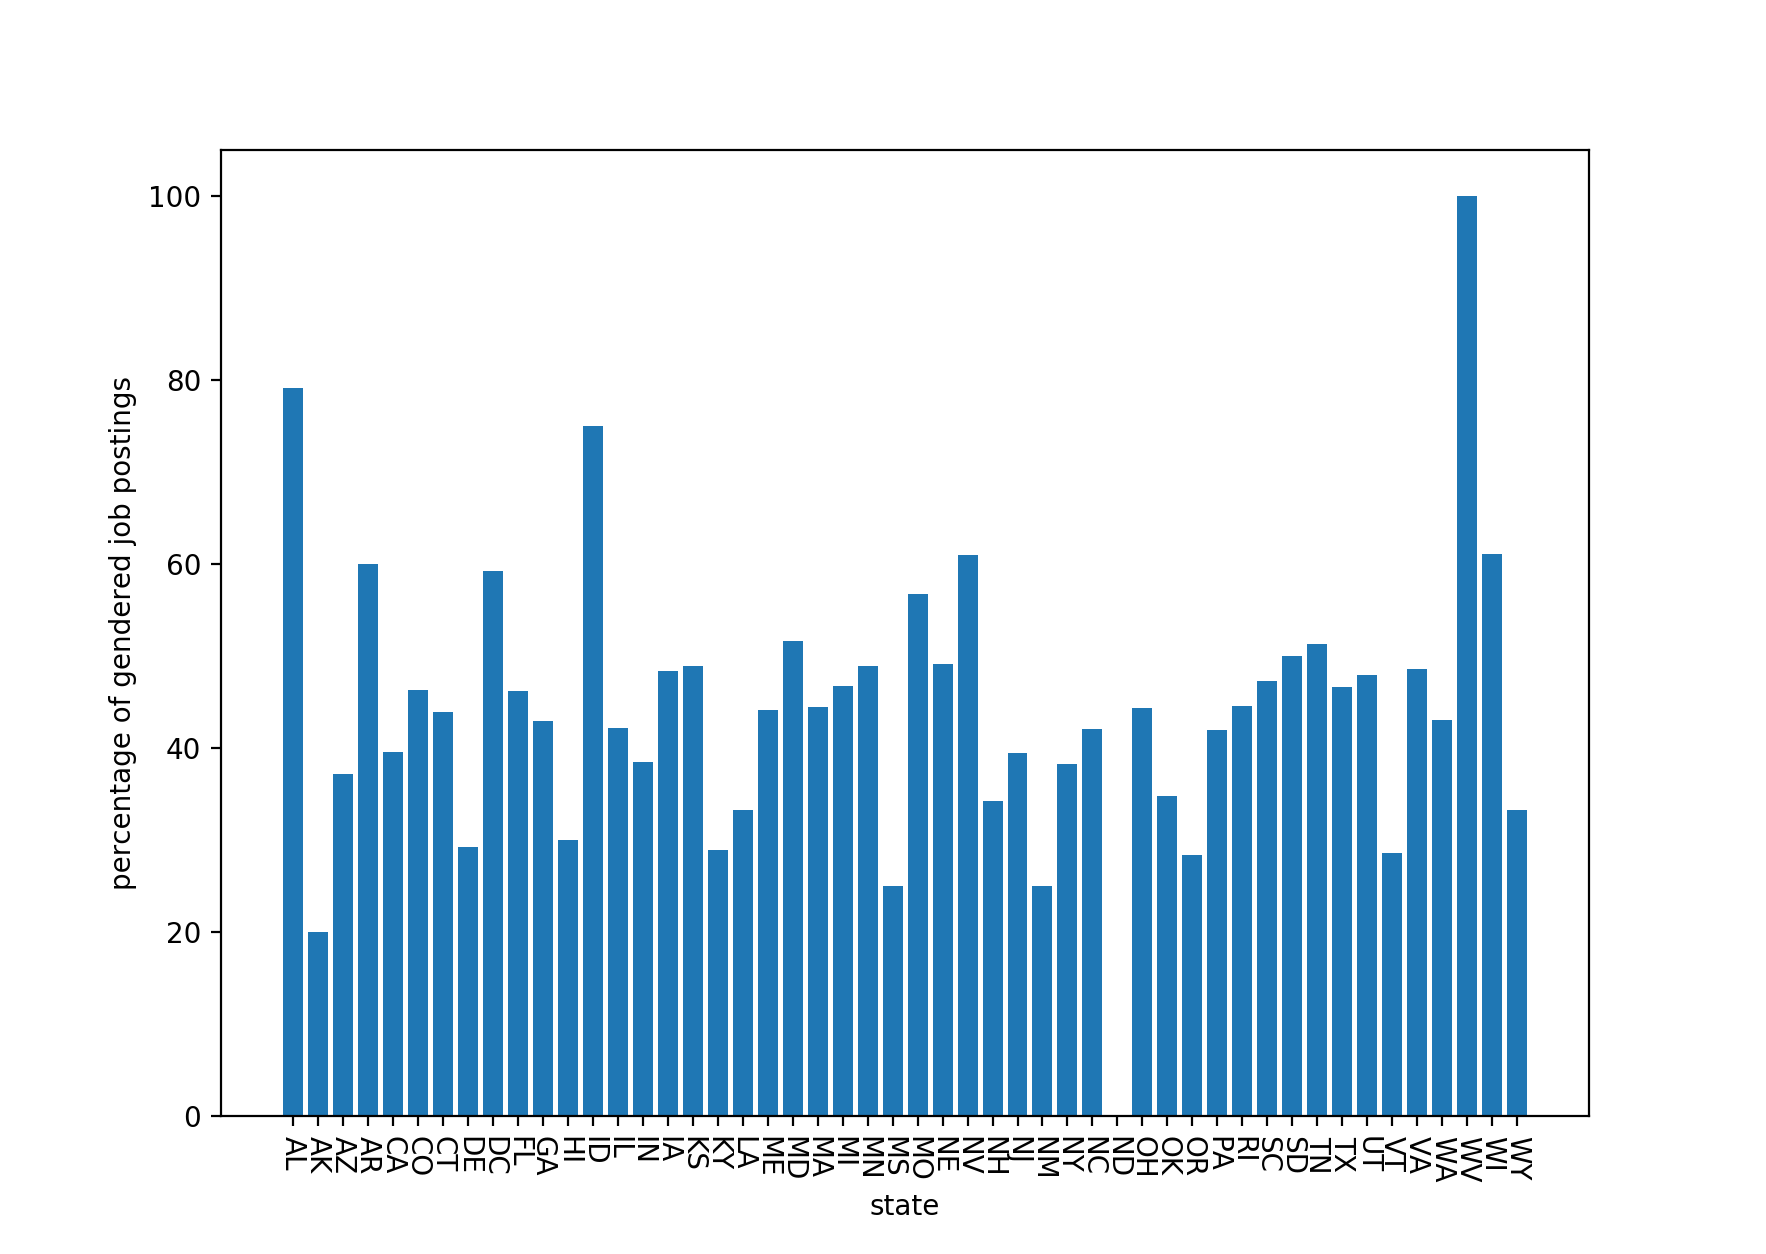

In [86]:
fig

In [95]:
import sys
sys.path.insert(1, '../data')

In [96]:
import corpus

['competitive',
 'dominate',
 'leader',
 'rock star',
 'rockstar',
 'guru',
 'ninja',
 'hacker',
 'superhero',
 'prove themselves',
 'analyze',
 'determine',
 'crush it',
 'world class',
 'superior',
 'ambitious',
 'aggressive']

In [99]:
ps.stem('lead')

'lead'

In [157]:
mpronouns = ['he', 'him' ,'his']
fpronouns = ['she', 'her', 'hers']
pronounCounter = 0
mascPronounCounter = 0
femPronounCounter = 0
for index, row in data_set.iterrows():
    mcount = 0
    fcount = 0
    for word in mpronouns: 
        mcount += phraseCount(word, row.get('jobdescription'))
    for word in fpronouns: 
        fcount += phraseCount(word, row.get('jobdescription'))
    if mcount + fcount > 0:
        pronounCounter +=1 
    if mcount > fcount: 
        mascPronounCounter += 1
    if mcount < fcount: 
        femPronounCounter += 1
        
print('number of jobs that have gendered pronouns:', pronounCounter)
print('more masculine pronouns:', mascPronounCounter)
print('more feminine pronouns:', femPronounCounter)

number of jobs that have gendered pronouns: 744
more masculine pronouns: 206
more feminine pronouns: 27


744 jobs w/ pronouns 